<a href="https://colab.research.google.com/github/fjme95/algebra-lineal-para-machine-learning/blob/main/6_Compressed_Sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencias

In [ ]:
!pip install wget

In [ ]:
import os

import cv2, wget
import numpy as np

import scipy.fft as spfft

import matplotlib.pyplot as plt

import cvxpy as cvx

from sklearn.linear_model import Lasso

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
np.random.seed(10)

# Funciones

Sirve para calcular la inversa de la Transformada Directa del Coseno para 2 dimensiones

In [ ]:
def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# Datos

Descargaremos una imagen de la web para trabajar con ella y la transformamos a escala de grises.

In [ ]:
filename = 'image.jpg'
if not os.path.isfile(filename):
    image_url = 'https://images.unsplash.com/photo-1633505190652-33f1b81d8a05?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=776&q=80'
    filename = wget.download(image_url, out = filename)


og_image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2GRAY)

Reescalamos la imagen para que no sea computacionalmente pesado para el algoritmo que utilizaremos

In [ ]:
scale_percent = 15 # percent of original size
width = int(og_image.shape[1] * scale_percent / 100)
height = int(og_image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
image = cv2.resize(og_image, dim, interpolation = cv2.INTER_AREA)
image.shape

(174, 116)

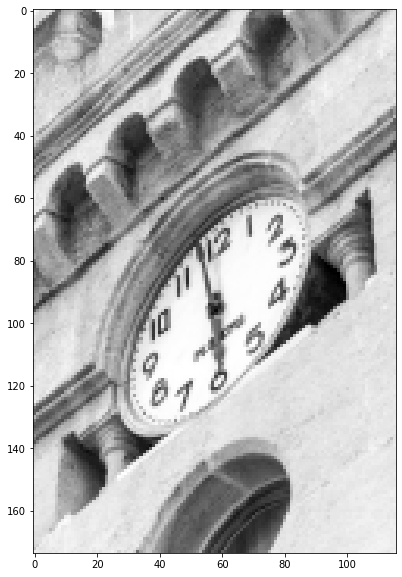

In [ ]:
plt.imshow(image, cmap = 'gray')

# Transformada de Fourier para "comprimir" una imagen

Más que centrarnos en la compresión de la imagen, veremos la idea detrás de compressed sensing para reconstruirla a partir de un vector disperso (sparse). 

Para esto, tomaremos la imagen, aplicaremos la transformada de fourier, eliminaremos las frecuencias abajo de un limite que elijamos y usaremos la transforma inversa de Fourier para regresar al "dominio de la imagen"

In [ ]:
# Hiperparámetro de compresión. Indica que la "compresión" se va a quedar con el k% de frecuencias más grandes
k = .5

# FT para dos dimensiones. Aplica la FT a las filas y luego a las columnas
img_fourier = np.fft.fft2(image)

# Ordena las frecuencias de mayor a menor. Nos va a servir para visualizar el dominio de frecuencias
img_fourier_shift = np.fft.fftshift(img_fourier)

# Ordenamos las frecuencias de menor a mayor. Nos va a servir para eliminar las frecuencias bajas
coef_sorted = np.sort(np.abs(img_fourier.reshape(-1)))

# Encontramos la frecuencia que es más grande que el (1-k)*100% de todas las frecuencias
trh = coef_sorted[np.int((1-k) * len(coef_sorted))]
idx = np.abs(img_fourier) > trh

img_fourier_downsampled = img_fourier * idx
img_fourier_downsampled_shift = np.fft.fftshift(img_fourier_downsampled)

# Nos ayuda a visualizar el dominoi de las frecuencias
frec_spc = np.log10(np.abs(img_fourier_shift).real)
frec_spc_downsampled = np.log10(np.abs(img_fourier_downsampled_shift).real)

# Reemplazamos -inf por 0 que fue resultado de escalar los valores con np.log10
frec_spc_downsampled = np.where(frec_spc_downsampled==-np.inf, 0, frec_spc_downsampled)

img_reconstructed = np.fft.ifft2(img_fourier_downsampled).real

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


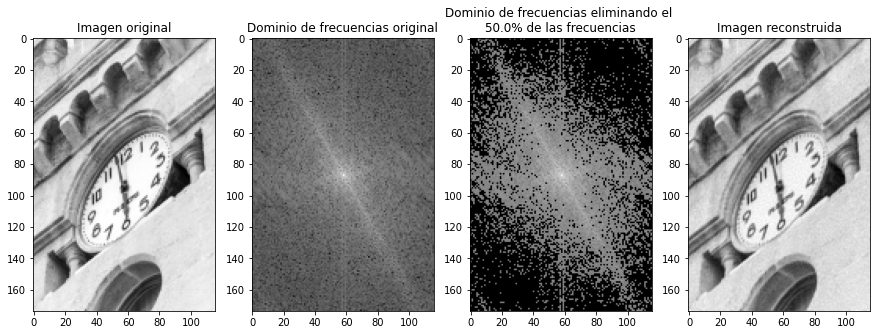

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (15, 15))

ax[0].imshow(image, cmap = 'gray')
ax[0].set_title('Imagen original')

ax[1].imshow(frec_spc, cmap='gray')
ax[1].set_title('Dominio de frecuencias original')

ax[2].imshow(frec_spc_downsampled, cmap='gray')
ax[2].set_title(f'Dominio de frecuencias eliminando el \n{(1-k)*100}% de las frecuencias')

ax[3].imshow(img_reconstructed, cmap='gray')
ax[3].set_title('Imagen reconstruida')

fig.show()

## Sobre la escases/dispersión (sparsity) del vector de frecuencias

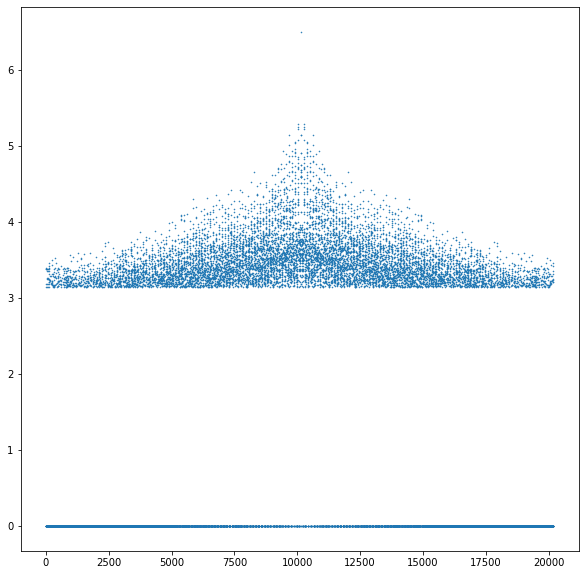

In [ ]:
plt.scatter(range(len(frec_spc_downsampled.flat)), frec_spc_downsampled.flat, s=.3)




# Compressed Sensing


Por lo anterior, podemos escribir la imagen como $$x = \psi s,$$ en donde $\psi$ es la base de fourier (para este caso ocuparemos la transformada directa del coseno para 2 dimensiones) y $s$ es nuestro vector "sparse" en el dominio de frecuencias.

Entonces, si tomamos $$y = \phi x$$ de tal modo que $C$ toma ciertos pixeles de $x$ aleatoriamente, podemos escribir a $y$ como $$y = \phi \psi s.$$ 

Finalmente, definamos $A \equiv \phi\psi$, sustituyendo obtenemos el siguiente sistema de ecuaciones $$y = As.$$

Si conocemos $y$, entonces nos queda solucionar un sistema de ecuaciones indeterminado. 

Compressed Sensing utiliza la norma $l1$ para obtener el vector $s$ que soluciona el sistema anterior ya que fomenta la escases (sparsity) en este vector. Es decir, compressed sensing busca solucionar 

\begin{align}
    \min_s \| s \|_1 \text{  s.a.  } \|A s - y \|_2 < \epsilon
\end{align}

Para facilitar la idea lo que es una base de fourier, a continuacion hay una gráfica que representa a la DCT

In [ ]:
m, n = image.shape
D = spfft.dct(np.eye(50), axis=0)

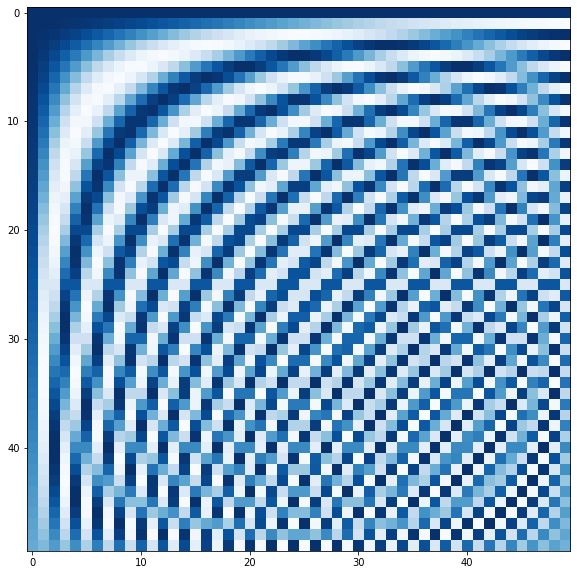

In [ ]:
plt.imshow(D, cmap = 'Blues')

Ahora utilizaremos Compressed Sensing en la imagen del inicio.

La idea detrás del por qué se ocupa el producto de Kronecker es la siguiente. 

Consideremos X la imagen en el dominio espectral y $D_i=idct(I_i)$, donde $I_i$ es la matriz identidad de tamaño $i$.  Entonces, la DCT cumple que $$dct(X) = dct(I_m) X.$$

Por lo que 

\begin{align}
idct2\left(X\right)&=idct\left(idct\left(X^T\right)^T\right)\\
&=D_m\left(D_nX^T\right)^T\\
&=D_mXD^T_n
\end{align}

También consideremos $vec(X)$, el operador que pone las columnas de $X$ unas encima de otras. Entonces,

\begin{align}
    vec(D_mXD^T_n)&= \left(D_n \otimes D_m\right)vec(X) \\
    &=(D_n \otimes D_m)x & \text{donde } x \equiv vec(X)
\end{align}

Esto quiere decir que $\psi = (D_n \otimes D_m)$

In [ ]:
m, n = image.shape

# Base de Fourier
psi = np.kron(
    spfft.idct(np.identity(n), norm='ortho', axis=0),
    spfft.idct(np.identity(m), norm='ortho', axis=0)
    )

In [ ]:
# fig, ax= plt.subplots(1, figsize=(50, 50))

# ax.imshow(psi.real, cmap='gist_heat')
# ax.set_title('Psi = Base de Fourier')

# fig.show()

In [ ]:
k_perc = .5
k = round(m * n * k_perc) # muestra del (k_perc * 100)%
phi_ = np.random.choice(m * n, k, replace=False) # indices de la máscara

b = image.T.flat[phi_]

In [ ]:
A = psi[phi_,:] # Equivalente a phi * psi

In [ ]:
# fig, ax= plt.subplots(1, figsize=(50, 50))

# ax.imshow(A.real, cmap='gist_heat')

# fig.show()

In [ ]:
%%time
lasso = Lasso(alpha=0.0001)
lasso.fit(A, b)

CPU times: user 2min 8s, sys: 22.4 s, total: 2min 30s
Wall time: 1min 20s


In [ ]:
aux = np.array(lasso.coef_).reshape(n, m).T # stack columns
# Get the reconstructed image
X = idct2(aux)

In [ ]:
image_sample = image.copy()


mask = np.ones(len(image_sample.T.flat), dtype=bool)
mask[phi_] = False

image_sample.T.flat[mask] = 0
image_sample = image_sample.reshape(m, n)

C = np.zeros(m * n)
C.T.flat[phi_] = 1
C = C.reshape(m, n)


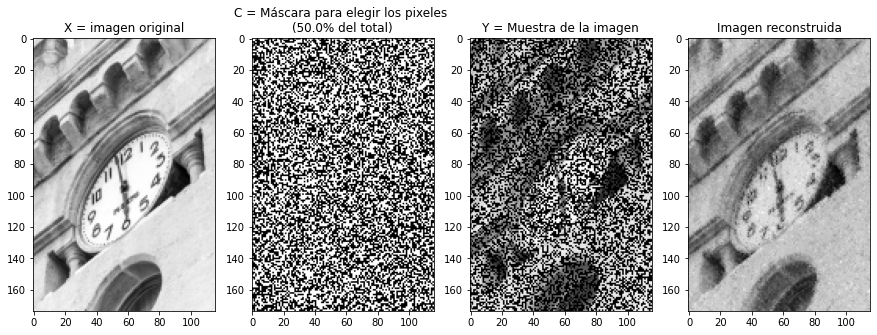

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15,15))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('X = imagen original')

ax[1].imshow(C, cmap = 'gray')
ax[1].set_title(f'phi = Máscara para elegir los pixeles \n({k_perc*100}% del total)')

ax[2].imshow(image_sample, cmap = 'gray')
ax[2].set_title('Y = Muestra de la imagen')

ax[3].imshow(X, cmap = 'gray')
ax[3].set_title('Imagen reconstruida')

fig.show()

# Notas

- El problema de optimización de compressed sensing es muy parecido al de LASSO, pero no es el mismo. Se uso esta optimización por motivos didácticos, pero lo ideal es usar un algoritmo de optimización para problemas convexos. Inclusive hay una manera de optimizar el algoritmo de tal modo que la matriz $A$ no se tiene que calcular.


# TODO

- Escribir el algoritmo de compressed sensing como una función.
- Observar el resultado para diferentes valores de ```k_perc``` para el tamaño de la muestra de la imagen y de ```alpha``` para LASSO.
- (opcional) Cambiar la optimización de la función.